In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import load_model
import os
import tensorflow as tf


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = r'/content/drive/MyDrive/Final_DataSet/Train'
valid_path = r'/content/drive/MyDrive/Final_DataSet/Test'


In [ ]:
# Import the mobilenet library as shown below and add preprocessing layer to the front of MobileNet
# Here we will be using imagenet weights

mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob(r'/content/drive/MyDrive/Final_DataSet/Train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(mobilenet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model_mobilenet_final = Model(inputs=mobilenet.input, outputs=prediction)

In [ ]:
# tell the model what cost and optimization method to use
model_mobilenet_final.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 8145 images belonging to 19 classes.
Found 2010 images belonging to 19 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
history_mobilenet_final = model_mobilenet_final.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

model_mobilenet_final.save('mobilenet_final_model.h5')
print("model saved to Disk.")

Epoch 1/10
255/255 [==============================] - 2920s 11s/step - loss: 2.4446 - accuracy: 0.8244 - val_loss: 1.7278 - val_accuracy: 0.8955
Epoch 2/10
255/255 [==============================] - 761s 3s/step - loss: 1.4573 - accuracy: 0.9164 - val_loss: 2.1553 - val_accuracy: 0.9090
Epoch 3/10
255/255 [==============================] - 754s 3s/step - loss: 1.0175 - accuracy: 0.9432 - val_loss: 1.5771 - val_accuracy: 0.9388
Epoch 4/10
255/255 [==============================] - 746s 3s/step - loss: 0.9338 - accuracy: 0.9508 - val_loss: 2.4626 - val_accuracy: 0.9264
Epoch 5/10
255/255 [==============================] - 728s 3s/step - loss: 0.7859 - accuracy: 0.9637 - val_loss: 1.4453 - val_accuracy: 0.9522
Epoch 6/10
255/255 [==============================] - 717s 3s/step - loss: 0.6699 - accuracy: 0.9694 - val_loss: 2.1688 - val_accuracy: 0.9363
Epoch 7/10
255/255 [==============================] - 724s 3s/step - loss: 0.6870 - accuracy: 0.9664 - val_loss: 2.3389 - val_accuracy: 0.93

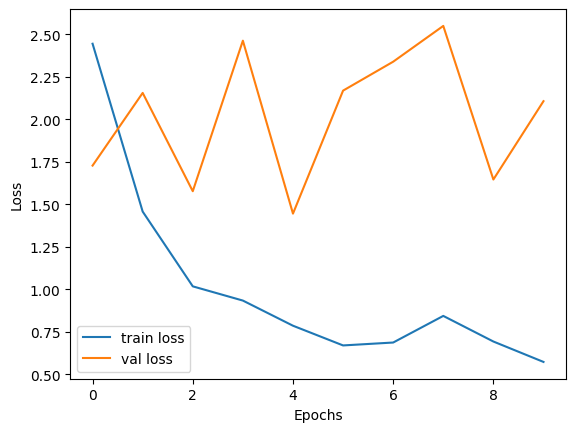

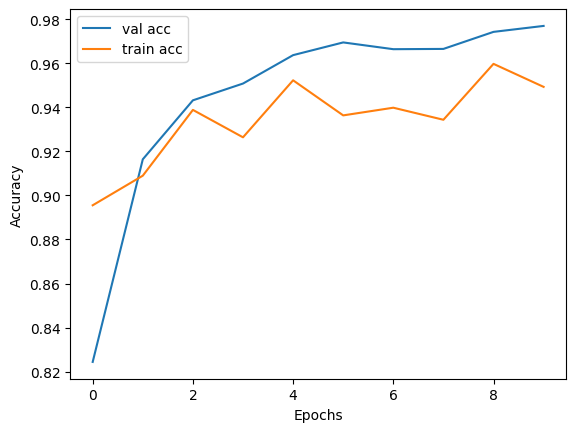

In [ ]:
#plot the loss
plt.plot(history_mobilenet_final.history['loss'], label='train loss')
plt.plot(history_mobilenet_final.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# plot the accuracy
plt.plot(history_mobilenet_final.history['accuracy'], label='val acc')
plt.plot(history_mobilenet_final.history['val_accuracy'], label='train acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# dirname = os.path.join(os.path.dirname(__file__))
model_mobilenet_new_final = load_model('mobilenet_final_model.h5')
print("model loaded.")

model loaded.


In [ ]:
model_mobilenet_new_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_data_generator = test_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


Found 2010 images belonging to 19 classes.


In [ ]:
predictions = model_mobilenet_new_final.predict(test_data_generator, steps=test_steps_per_epoch)


63/63 [==============================] - 117s 2s/step


In [ ]:
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

print(test_data_generator.classes)
print(predicted_classes)

[ 0  0  0 ... 18 18 18]
[ 0  0  0 ... 18 17 18]


In [ ]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
cmat = confusion_matrix(true_classes, predicted_classes)
acc = accuracy_score(true_classes, predicted_classes)
print(report)
print(cmat)
print(acc)

                        precision    recall  f1-score   support

          Apple_blotch       0.82      0.70      0.76        64
         Apple_healthy       0.91      0.93      0.92       137
          Apple_rotten       0.96      0.99      0.97       136
            Apple_scab       1.00      1.00      1.00        42
           Banana_firm       0.90      1.00      0.95       148
 Banana_heavilybruised       0.94      0.93      0.93       136
Banana_slightlybruised       0.95      0.88      0.91       159
   GreenChilli_damaged       1.00      1.00      1.00        27
     GreenChilli_dried       1.00      0.95      0.97       100
       GreenChilli_old       0.98      0.98      0.98        52
      GreenChilli_ripe       0.84      0.93      0.88        40
    GreenChilli_unripe       0.93      0.91      0.92        45
       Orange_greening       0.89      0.99      0.94       136
        Orange_healthy       0.98      0.87      0.93        71
         Orange_rotten       1.00      

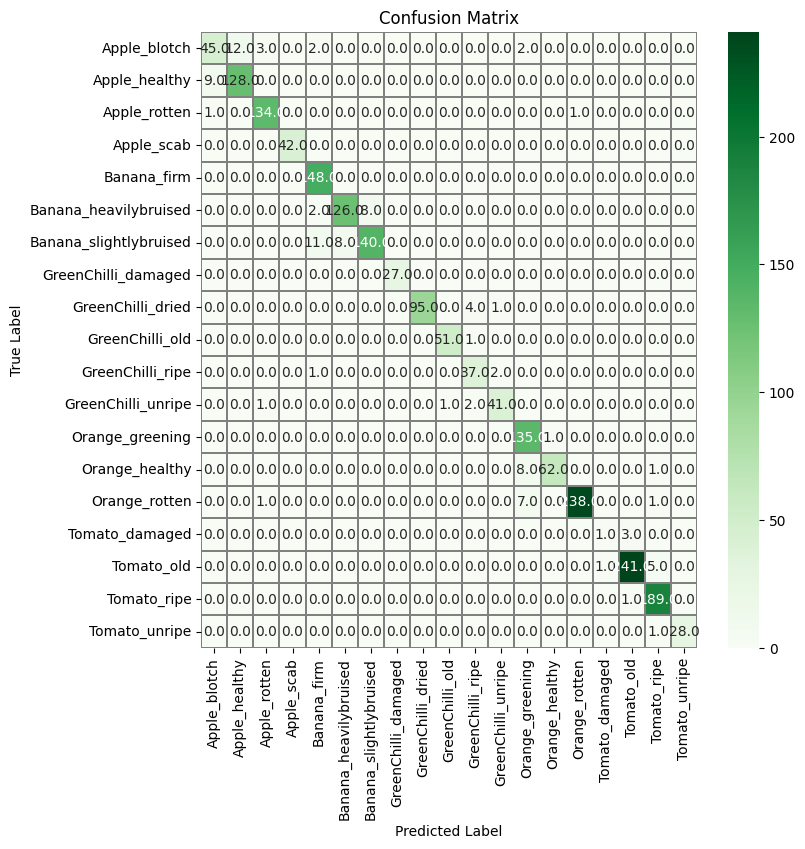

In [ ]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Apple_blotch','Apple_healthy','Apple_rotten','Apple_scab','Banana_firm','Banana_heavilybruised','Banana_slightlybruised','GreenChilli_damaged','GreenChilli_dried','GreenChilli_old','GreenChilli_ripe','GreenChilli_unripe','Orange_greening','Orange_healthy','Orange_rotten','Tomato_damaged','Tomato_old','Tomato_ripe','Tomato_unripe'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_yticklabels(['Apple_blotch','Apple_healthy','Apple_rotten','Apple_scab','Banana_firm','Banana_heavilybruised','Banana_slightlybruised','GreenChilli_damaged','GreenChilli_dried','GreenChilli_old','GreenChilli_ripe','GreenChilli_unripe','Orange_greening','Orange_healthy','Orange_rotten','Tomato_damaged','Tomato_old','Tomato_ripe','Tomato_unripe'])

plt.title("Confusion Matrix")
plt.show()

In [ ]:
def get_tpr_fnr_fpr_tnr(cm):
    """
    This function returns class-wise TPR, FNR, FPR & TNR
    [[cm]]: a 2-D array of a multiclass confusion matrix
            where horizontal axes represent actual classes
            and vertical axes represent predicted classes
    {output}: a dictionary of class-wise accuracy parameters
    """
    dict_metric = dict()
    n = len(cm[0])
    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)
    array_sum = sum(sum(cm))
    #initialize a blank nested dictionary
    for i in range(1, n+1):
        keys = str(i)
        dict_metric[keys] = {"TPR":0, "FNR":0, "FPR":0, "TNR":0}
    # calculate and store class-wise TPR, FNR, FPR, TNR
    for i in range(n):
        for j in range(n):
            if i == j:
                keys = str(i+1)
                tp = cm[i, j]
                fn = row_sums[i] - cm[i, j]
                dict_metric[keys]["TPR"] = tp / (tp + fn)
                dict_metric[keys]["FNR"] = fn / (tp + fn)
                fp = col_sums[i] - cm[i, j]
                tn = array_sum - tp - fn - fp
                dict_metric[keys]["FPR"] = fp / (fp + tn)
                dict_metric[keys]["TNR"] = tn / (fp + tn)
    return dict_metric

In [ ]:
import pandas as pd
df = pd.DataFrame(get_tpr_fnr_fpr_tnr(confusion_mtx)).transpose()
classes = ['Apple_blotch','Apple_healthy','Apple_rotten','Apple_scab','Banana_firm','Banana_heavilybruised','Banana_slightlybruised','GreenChilli_damaged','GreenChilli_dried','GreenChilli_old','GreenChilli_ripe','GreenChilli_unripe','Orange_greening','Orange_healthy','Orange_rotten','Tomato_damaged','Tomato_old','Tomato_ripe','Tomato_unripe']
df['CLASSES'] = classes
df.set_index('CLASSES', inplace=True)
df

,TPR,FNR,FPR,TNR
CLASSES,,,,
Apple_blotch,0.703125,0.296875,0.005139,0.994861
Apple_healthy,0.934307,0.065693,0.006407,0.993593
Apple_rotten,0.985294,0.014706,0.002668,0.997332
Apple_scab,1.000000,0.000000,0.000000,1.000000
Banana_firm,1.000000,0.000000,0.008593,0.991407
Banana_heavilybruised,0.926471,0.073529,0.004269,0.995731
Banana_slightlybruised,0.880503,0.119497,0.004322,0.995678
GreenChilli_damaged,1.000000,0.000000,0.000000,1.000000
GreenChilli_dried,0.950000,0.050000,0.000000,1.000000


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenet_new_final)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

KeyboardInterrupt: ignored

In [ ]:
print("Mobilenet analysis: ")
print("TPR average: ",df["TPR"].mean())
print("FPR average: ",df["FPR"].mean())
print("TNR average: ",df["TNR"].mean())
print("FNR average: ",df["FNR"].mean())

Mobilenet analysis: 
TPR average:  0.9058942945130736
FPR average:  0.002858193302300445
TNR average:  0.9971418066976995
FNR average:  0.0941057054869264
